In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/exl-health-ml-hackathon/sample_submission.csv
/kaggle/input/exl-health-ml-hackathon/train.csv
/kaggle/input/exl-health-ml-hackathon/test.csv


In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE,SMOTENC,SVMSMOTE
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score
import warnings
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import lightgbm as lgb
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
import catboost
from tqdm import tqdm
import time
import datetime
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from copy import deepcopy
import pprint
import shap
import os
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.option_context('mode.use_inf_as_na', True)

***Reading Dataset***

In [72]:
train = pd.read_csv('/kaggle/input/exl-health-ml-hackathon/train.csv')
test = pd.read_csv('/kaggle/input/exl-health-ml-hackathon/test.csv')

In [73]:
train.shape, test.shape

((23738, 37), (8902, 36))

***Dataset Summary***

In [74]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23738 entries, 0 to 23737
Data columns (total 37 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          23738 non-null  int64  
 1   feature_1   23660 non-null  float64
 2   feature_2   23627 non-null  float64
 3   feature_3   23688 non-null  float64
 4   feature_4   23553 non-null  float64
 5   feature_5   23722 non-null  float64
 6   feature_6   23702 non-null  float64
 7   feature_7   23673 non-null  float64
 8   feature_8   23670 non-null  float64
 9   feature_9   23639 non-null  float64
 10  feature_10  21719 non-null  float64
 11  feature_11  21719 non-null  float64
 12  feature_12  22919 non-null  float64
 13  feature_13  23011 non-null  float64
 14  feature_14  23030 non-null  float64
 15  feature_15  12381 non-null  float64
 16  feature_16  23384 non-null  float64
 17  feature_17  23414 non-null  float64
 18  feature_18  23413 non-null  float64
 19  feature_19  23349 non-nul

In [75]:
train['level'].value_counts()

level
0    11818
1     6878
3     4174
2      868
Name: count, dtype: int64

***Droping columns with null values greater than 4000***

In [76]:
x = train.isnull().sum().reset_index(name = 'count')
cols_remove = list(x[x['count'] >= 4000]['index'])
cols_remove

['feature_15', 'feature_29', 'feature_34', 'feature_35']

In [77]:
train = train.drop(columns = cols_remove)
test = test.drop(columns = cols_remove)

In [78]:
category_columns = list(train.select_dtypes(['object']).columns)
numeric_columns = list(train.select_dtypes(['float64']).columns)
print("Numeric Columns : ", numeric_columns)
print("Categorical Columns: ", category_columns)

Numeric Columns :  ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_32', 'feature_33']
Categorical Columns:  ['feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_30', 'feature_31']


***Missing value Imputation***

In [79]:
train[numeric_columns].describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_32,feature_33
count,23660.000000,23627.000000,23688.000000,23553.000000,23722.000000,23702.000000,23673.000000,23670.000000,23639.000000,21719.000000,21719.000000,22919.000000,23011.000000,23030.000000,23384.000000,23414.000000,23413.000000,23349.000000,23294.000000,23279.000000,23514.000000,23514.000000
mean,1.601014,1.250434,0.049519,0.721904,0.068375,0.822251,0.353103,0.332066,0.670037,0.197293,0.312998,0.273049,0.079658,0.104125,3.797041,2.277398,2.345022,3.980170,2.646132,2.119249,0.883729,0.539551
std,0.911614,0.617721,0.216953,0.448071,0.252394,0.382309,0.477944,0.470964,0.470209,0.397964,0.463724,0.445535,0.270768,0.305429,1.016369,1.264548,1.360786,1.106807,1.380107,1.329233,0.755763,0.930807
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


***Categorical Encoder & Missing Value Imputation with most frequent value***

In [80]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

class GeneralTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoders = {}
        self.most_frequent_values = {}

    def fit(self, X, y=None):
        for column in X.columns:
            # Impute missing values with the most frequent value
            self.most_frequent_values[column] = X[column].mode()[0]
            X[column].fillna(self.most_frequent_values[column], inplace=True)

            # Fit label encoder if column is categorical
            if X[column].dtype == 'object':
                le = LabelEncoder()
                le.fit(X[column])
                self.label_encoders[column] = le
        return self

    def transform(self, X):
        X = X.copy()
        for column in X.columns:
            # Impute missing values
            X[column].fillna(self.most_frequent_values[column], inplace=True)

            # Encode categorical columns
            if column in self.label_encoders:
                X[column] = self.label_encoders[column].transform(X[column])
        return X


In [81]:
from sklearn.pipeline import Pipeline

# Create the pipeline
pipeline = Pipeline(steps=[
    ('general_transformer', GeneralTransformer())
])

pipeline

Pipeline(steps=[('general_transformer', GeneralTransformer())])

In [82]:
cols = ['feature_1',
 'feature_2',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_14',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_25',
 'feature_26',
 'feature_28',
 'feature_30',
 'feature_31',
 'feature_32',
 'feature_33']
len(cols)

23

In [83]:
x = train.drop(columns = ['level','id'])
# x = x[cols]
y = train[['level']]
x = pipeline.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                        test_size=0.2,
                                                        random_state=43,
                                                        stratify=y)
test = test.drop(columns = ['id'])
test = pipeline.fit_transform(test)
# test = test[cols]

In [105]:
from imblearn.under_sampling import RandomUnderSampler

# Set up random undersampling
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)

In [106]:
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)  # 'auto' balances all classes
x_resampled, y_resampled = undersample.fit_resample(x, y)

In [99]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier

In [107]:
class_weights = [1 / 0.497852, 1 / 0.289746, 1 / 0.036566, 1 / 0.175836]
# bp = {'n_estimators': 4000,
#  'task_type': 'CPU',
#  'eval_metric': 'WKappa',
#  'one_hot_max_size': 2,
#  'silent': True,
#  'random_seed': 5,
#  'loss_function': 'MultiClass',
#  'learning_rate': 0.5821986227163919,
#  'max_depth': 5,
#  'colsample_bylevel': 1.0,
#  'bagging_temperature': 29.21465216661629,
#  'random_strength': 10.168390152410026,
#  'reg_lambda': 100.0}
cb= CatBoostClassifier(loss_function='MultiClass',
    task_type="CPU",
    learning_rate=0.01,
    iterations=2000,
    od_type="Iter",
    early_stopping_rounds=500,
    random_seed=24,
    silent=True
)


In [92]:
cv_scores = cross_val_score(cb, x_resampled, y_resampled, cv=5, scoring='f1_weighted')
mean_cv_score = cv_scores.mean()

print(f'Cross-Validated Weighted F1 Score: {mean_cv_score:.2f}')

Cross-Validated Weighted F1 Score: 0.65


In [93]:
cv_scores

array([0.6958153 , 0.66979654, 0.65165643, 0.62370464, 0.6099365 ])

In [108]:
y_resampled.level.value_counts()

level
0    868
1    868
2    868
3    868
Name: count, dtype: int64

In [109]:
cb.fit(x_resampled, y_resampled)

In [110]:
pred = cb.predict(x_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.85      0.64      0.73      2364
           1       0.66      0.62      0.64      1376
           2       0.17      0.72      0.28       173
           3       0.57      0.64      0.60       835

    accuracy                           0.64      4748
   macro avg       0.56      0.66      0.56      4748
weighted avg       0.72      0.64      0.67      4748



In [104]:
final_f1 = f1_score(y_test, pred, average='weighted')
print(f'Final Weighted F1 Score on Test Set: {final_f1:.5f}')

Final Weighted F1 Score on Test Set: 0.63198


In [140]:
feature_importance = cb.get_feature_importance()
feature_names = x_train.columns

# Display feature importance
for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance:.2f}")

Feature: feature_1, Importance: 3.01
Feature: feature_2, Importance: 2.46
Feature: feature_7, Importance: 1.26
Feature: feature_9, Importance: 1.53
Feature: feature_10, Importance: 8.60
Feature: feature_11, Importance: 7.64
Feature: feature_12, Importance: 1.96
Feature: feature_14, Importance: 2.30
Feature: feature_16, Importance: 7.37
Feature: feature_17, Importance: 6.38
Feature: feature_18, Importance: 3.92
Feature: feature_19, Importance: 9.02
Feature: feature_20, Importance: 10.33
Feature: feature_21, Importance: 4.13
Feature: feature_22, Importance: 7.36
Feature: feature_23, Importance: 3.00
Feature: feature_24, Importance: 2.32
Feature: feature_25, Importance: 2.01
Feature: feature_26, Importance: 2.15
Feature: feature_27, Importance: 1.11
Feature: feature_28, Importance: 1.58
Feature: feature_30, Importance: 4.20
Feature: feature_31, Importance: 2.10
Feature: feature_32, Importance: 1.84
Feature: feature_33, Importance: 2.41


In [141]:
f = pd.DataFrame(zip(feature_names, feature_importance), columns = ['feature','score'])

In [155]:
cols = f[f['score'] > 1.5].feature.tolist()
cols

['feature_1',
 'feature_2',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_14',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_25',
 'feature_26',
 'feature_28',
 'feature_30',
 'feature_31',
 'feature_32',
 'feature_33']

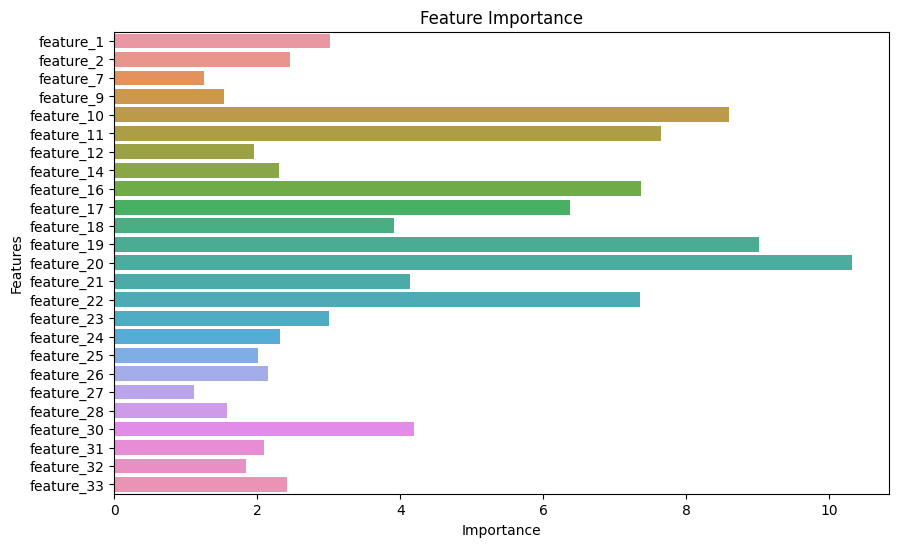

In [143]:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_names)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [61]:
sub = pd.read_csv('/kaggle/input/exl-health-ml-hackathon/sample_submission.csv')
sub.head()

,id,level
0,24721,0
1,25833,0
2,24144,0
3,13222,0
4,18675,0


In [62]:
final_preds = cb.predict(test)

In [63]:
sub['level'] = final_preds

In [64]:
 sub.head(10)

,id,level
0,24721,0
1,25833,0
2,24144,3
3,13222,0
4,18675,3
5,4657,0
6,19201,0
7,21845,0
8,23489,0
9,11220,1


In [65]:
sub.level.value_counts(normalize = True)

level
0    0.511009
1    0.284992
3    0.184902
2    0.019097
Name: proportion, dtype: float64

In [66]:
train.level.value_counts(normalize = True)

level
0    0.497852
1    0.289746
3    0.175836
2    0.036566
Name: proportion, dtype: float64

In [67]:
sub.columns

Index(['id', 'level'], dtype='object')

In [68]:
sub.head()

,id,level
0,24721,0
1,25833,0
2,24144,3
3,13222,0
4,18675,3


In [69]:
sub.to_csv('submission_file1.csv', index = False)

In [ ]:
.feature_importances_

In [ ]:
all_importances = np.zeros(x_train.shape[1])
for estimator in balanced_bagging_classifier.estimators_:
    all_importances += estimator.feature_importances_

# Average the importances
feature_importances = all_importances / len(balanced_bagging_classifier.estimators_)

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(x_train.columns, feature_importances):
    print(f"{feature}: {importance:.4f}")